In [1]:
import pandas as pd
import numpy as np
from numpy import nan
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

In [2]:
#TextFileReader = pd.read_csv("ProdLog202202.AU.nobot.csv", chunksize = 1000000, usecols= ['PartitionKey', "Timestamp", 'UserHostAddress', 'Path', 
#                                                                                "WhatText", "Postcode", "CategoryID"])  # the number of rows per chunk

#dfList = []
#for df in TextFileReader:
#    dfList.append(df)

#df = pd.concat(dfList,sort=False)
#df.to_csv('202206subset.csv', index=False)

In [2]:
df = pd.read_csv("202202subset.csv")
df.drop("Timestamp", inplace=True, axis=1)
df.info() # row = 4915450, only AU ip address without bots 
print(len(df["UserHostAddress"].unique())) # how many unique IP address, 233026 unique IP address

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915450 entries, 0 to 4915449
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   PartitionKey     int64  
 1   UserHostAddress  object 
 2   Path             object 
 3   WhatText         object 
 4   CategoryID       float64
 5   Postcode         float64
dtypes: float64(2), int64(1), object(3)
memory usage: 225.0+ MB
233026


In [3]:
# drop UserHostAddress and Path duplicates so that each row now represents 1 demand.
df = df.drop_duplicates(subset=['UserHostAddress', 'Path'], keep='first')
print(len(df["UserHostAddress"].unique()))
print(df.shape)
df = df.drop_duplicates(subset=['UserHostAddress', 'CategoryID'], keep='first')
print(len(df["UserHostAddress"].unique()))
print(df.shape)
df = df.drop_duplicates(subset=['UserHostAddress', 'WhatText'], keep='first')
print(len(df["UserHostAddress"].unique()))
print(df.shape)

#df = df[df.WhatText != "-"] 
#df = df[df.WhatText != " "]
df["WhatText"] = df["WhatText"].replace("-", np.nan)
df["WhatText"] = df["WhatText"].replace(" ", np.nan)

233026
(1660972, 6)
233026
(433460, 6)
233026
(233727, 6)


In [4]:
# preprocessing for postcode
ip_info = pd.read_csv("IPInfo.David.20221022.csv", usecols= ['countryName', "zipCode", "isCrawler", "ipaddress"])
ip_info = ip_info.rename(columns = {'ipaddress': 'UserHostAddress'}, inplace = False)
ip_info = ip_info.drop_duplicates(subset=['UserHostAddress'], keep='first')
df = pd.merge(df, ip_info, on='UserHostAddress', how='left')
df = df[df.UserHostAddress.notnull()]
print(df.shape)
df.head()

C:\Users\mib67\AppData\Local\Temp\ipykernel_7176\798579167.py:2: DtypeWarning: Columns (14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  ip_info = pd.read_csv("IPInfo.David.20221022.csv", usecols= ['countryName', "zipCode", "isCrawler", "ipaddress"])


(233727, 9)


,PartitionKey,UserHostAddress,Path,WhatText,CategoryID,Postcode,countryName,zipCode,isCrawler
0,20220201,2001:8004:2771:4272:9c6c:486c:6cac:d9b7,/api/a/pagestatus,NaN,NaN,NaN,Australia,1001,False
1,20220201,121.222.196.73,/Manage/Dashboard/GetRecentUpdates,NaN,NaN,NaN,Australia,NaN,False
2,20220201,203.170.14.66,/Manage/Dashboard/GetRecentUpdates,NaN,NaN,NaN,Australia,4000,False
3,20220201,2001:8003:ddef:5500:c1df:e3e6:264c:fc09,/Manage/Dashboard/GetRecentUpdates,NaN,NaN,NaN,Australia,3001,False
4,20220201,49.2.203.158,/Manage/Dashboard/GetRecentUpdates,NaN,NaN,NaN,Australia,NaN,False


In [5]:
df["Postcode"] = df['Postcode'].fillna(df["zipCode"])
df = df[df.Postcode.notnull()]
df["Postcode_4XXX"] = df["Postcode"].str.startswith("4")
df = df[df.Postcode_4XXX == True]
df.drop("Postcode_4XXX", inplace=True, axis=1)
df.drop("zipCode", inplace=True, axis=1)
print(df.shape) # 50096 rows after filter out the countryName and isCrawler of IP, also filter out missing value in Postcode
df.head()

(50096, 8)


,PartitionKey,UserHostAddress,Path,WhatText,CategoryID,Postcode,countryName,isCrawler
2,20220201,203.170.14.66,/Manage/Dashboard/GetRecentUpdates,NaN,NaN,4000,Australia,False
13,20220201,125.168.245.186,/api/a/pagestatus,NaN,NaN,4215,Australia,False
14,20220201,1.146.68.155,/Queensland/Gold_Coast/Legal_Assistance___Information_Services/General_Legal_Assistance___Information/2566/101705/Family_Relationship_Centre_-_Ashmore,NaN,99.0,4102,Australia,False
20,20220201,58.161.74.247,/Queensland/Toowoomba/Recreation___Leisure/Crafts/7872/107696/Toowoomba_Knit_and_Crochet_Group,NaN,129.0,4000,Australia,False
32,20220201,2001:8003:1625:1600:440:98e2:ae7b:670a,/Victoria/Horsham/Health_Services/Drug___Alcohol_Services/44939/177137/Alcoholics_Anonymous_-_Horsham,NaN,79.0,4215.0,Australia,False


In [6]:
# preprocessing for WhatText
category = pd.read_csv("CIE_category.csv")
category = category[["ID", "Name"]]
category = category.rename(columns = {'ID': 'CategoryID'}, inplace = False)
category = category.rename(columns = {'Name': 'CategoryName'}, inplace = False)
category['CategoryID'] = category['CategoryID'].astype("float64")
category = category.drop_duplicates(keep='first') # There are fucking duplicates in categories, are you fucking serious!?
df = pd.merge(df, category, on='CategoryID', how='left')
print(df.shape)
df.head()

(50096, 9)


,PartitionKey,UserHostAddress,Path,WhatText,CategoryID,Postcode,countryName,isCrawler,CategoryName
0,20220201,203.170.14.66,/Manage/Dashboard/GetRecentUpdates,NaN,NaN,4000,Australia,False,NaN
1,20220201,125.168.245.186,/api/a/pagestatus,NaN,NaN,4215,Australia,False,NaN
2,20220201,1.146.68.155,/Queensland/Gold_Coast/Legal_Assistance___Information_Services/General_Legal_Assistance___Information/2566/101705/Family_Relationship_Centre_-_Ashmore,NaN,99.0,4102,Australia,False,General Legal Assistance & Information
3,20220201,58.161.74.247,/Queensland/Toowoomba/Recreation___Leisure/Crafts/7872/107696/Toowoomba_Knit_and_Crochet_Group,NaN,129.0,4000,Australia,False,Crafts
4,20220201,2001:8003:1625:1600:440:98e2:ae7b:670a,/Victoria/Horsham/Health_Services/Drug___Alcohol_Services/44939/177137/Alcoholics_Anonymous_-_Horsham,NaN,79.0,4215.0,Australia,False,Drug & Alcohol Services


In [7]:
# get the category name for corresponding category ID, use category name to fill the missing value in WhatText
df["WhatText"] = df['WhatText'].fillna(df["CategoryName"])
df["Path_1"] = df["Path"].str.split("/").str[-1]
df["Path_2"] = df["Path"].str.split("/").str[-2]
df["WhatText"] = df['WhatText'].fillna(df["Path_1"])
df["WhatText"] = df['WhatText'].str.lower()
df["Path_2"] = df['Path_2'].str.lower()

df.to_csv('202202_preprocessed.csv', index=False)

In [19]:
df = pd.read_csv("202202_preprocessed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50096 entries, 0 to 50095
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PartitionKey     50096 non-null  int64  
 1   UserHostAddress  50096 non-null  object 
 2   Path             50096 non-null  object 
 3   WhatText         48902 non-null  object 
 4   CategoryID       34549 non-null  float64
 5   Postcode         50096 non-null  float64
 6   countryName      50096 non-null  object 
 7   isCrawler        50069 non-null  object 
 8   CategoryName     32154 non-null  object 
 9   Path_1           48830 non-null  object 
 10  Path_2           48989 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 4.2+ MB


In [20]:
# filter out values that related to system 
df = df[df.WhatText != "pagestatus"]
df = df[df.WhatText != "api-info"]
df = df[df.WhatText != "getresults"]
df = df[df.WhatText != "terms_and_conditions"]
df = df[df.WhatText != "register"]
df = df[df.WhatText != "local"]
df = df[df.WhatText != "search"]
df = df[df.WhatText != "nearme"]
df = df[df.WhatText != "opendata"]
df = df[df.WhatText != "tags"]
df = df[df.WhatText != "organisations"]
df = df[df.WhatText != "getservicebadges"]
df = df[df.WhatText != "services"]
df = df[df.WhatText != "log"]
df = df[df.WhatText != "id"]
df = df[df.WhatText != "councils"]
df = df[df.WhatText != "council"]
df = df[df.WhatText != "getcouncil"]
df = df[df.WhatText != " "]
df = df[df.WhatText != "getappid"]
df = df[df.WhatText != "click"]
df = df[df.WhatText != "savedevicetoken"]
df = df[df.WhatText != "login"]
df = df[df.WhatText != "file"]
df = df[df.WhatText != "verifyemail"]
df = df[df.WhatText != "redirect"]
df = df[df.WhatText != "unsubscribe"]
df = df[df.WhatText != "account"]
df = df[df.WhatText != "bylocalityid"]
df = df[df.WhatText != "categories"]
df = df[df.WhatText != "category"]
df = df[df.WhatText != "directory"]
df = df[df.WhatText != "results"]
df = df[df.WhatText != "save"]
df = df[df.WhatText != "updatestatus"]

In [21]:
# replace all numeric search queries with No_Information value
df['WhatText'] = df['WhatText'].mask(pd.to_numeric(df['WhatText'], errors='coerce').notna())
df["WhatText"] = df['WhatText'].fillna(df["Path_2"])

df['WhatText'] = df['WhatText'].mask(pd.to_numeric(df['WhatText'], errors='coerce').notna())
df["WhatText"] = df['WhatText'].fillna("No_Information")

#second time filtering
df = df[df.WhatText != "id"]
df = df[df.WhatText != "councils"]
df = df[df.WhatText != "council"]
df = df[df.WhatText != "getcouncil"]
df = df[df.WhatText != " "]
df = df[df.WhatText != "log"]
df = df[df.WhatText != "getappid"]
df = df[df.WhatText != "click"]
df = df[df.WhatText != "savedevicetoken"]
df = df[df.WhatText != "login"]
df = df[df.WhatText != "file"]
df = df[df.WhatText != "verifyemail"]
df = df[df.WhatText != "redirect"]
df = df[df.WhatText != "unsubscribe"]
df = df[df.WhatText != "account"]
df = df[df.WhatText != "bylocalityid"]
df = df[df.WhatText != "categories"]
df = df[df.WhatText != "category"]
df = df[df.WhatText != "directory"]
df = df[df.WhatText != "results"]
df = df[df.WhatText != "save"]
df = df[df.WhatText != "updatestatus"]
df = df[df.WhatText != "contactus"]
df = df[df.WhatText != "meetings_"]
df = df[df.WhatText != "holidaynotice"]
df = df[df.WhatText != "location"]
df = df[df.WhatText != "memberfeatures"]
df = df[df.WhatText != "getrecentupdates"]
df = df[df.WhatText != "getinstanceresults"]
df = df[df.WhatText != "eventwidget"]
df = df[df.WhatText != "exploremycommunity"]
df = df[df.WhatText != "advanced"]

df = df.reset_index(drop = True)
df.drop("Path", inplace=True, axis=1)
df.drop("isCrawler", inplace=True, axis=1)
df.drop("Path_1", inplace=True, axis=1)
df.drop("Path_2", inplace=True, axis=1)
df.drop("UserHostAddress", inplace=True, axis=1)
df.drop("CategoryID", inplace=True, axis=1)
df.drop("countryName", inplace=True, axis=1)

print(df.shape) # row = 47088
df.head()

(47088, 4)


,PartitionKey,WhatText,Postcode,CategoryName
0,20220201,general legal assistance & information,4102.0,General Legal Assistance & Information
1,20220201,crafts,4000.0,Crafts
2,20220201,drug & alcohol services,4215.0,Drug & Alcohol Services
3,20220201,specialist homelessness services,4102.0,Specialist Homelessness Services
4,20220201,psychiatric services,4215.0,Psychiatric Services


In [22]:
# find out the unique_values that's not in the category dictionary, this is so hard...
name = category["CategoryName"].unique()
name = pd.DataFrame (name, columns = ['CategoryName'])
name = name.rename(columns = {'CategoryName': 'unique_values'}, inplace = False)
name["unique_values"] = name['unique_values'].str.lower()
value_counts = df["WhatText"].value_counts().rename_axis('unique_values').reset_index(name='counts')
df_diff = pd.concat([value_counts, name]).drop_duplicates("unique_values", keep=False)

In [23]:
df['CategoryName'] = np.where(df['WhatText'] == "No_Information", "No_Information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "events", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_clubs___interest_groups", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "welfare_assistance___services", "welfare assistance & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aboriginal_services", "aboriginal support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_centres__halls___facilities", "community halls", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "disability_services", "disability information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sport", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "youth_services", "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "accommodation_services", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "volunteering", "general volunteering services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "crisis___emergency_services", "general crisis and emergency services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cultural_and_migrant_services", "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "homeless_hotline", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "transport_services", "general transport services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "child_services", "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_housing_hub", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "st_vincent_de_paul_-_food_vouchers", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "magenta_community_services_pty_ltd_toowoomba", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "advocacy_services", "general advocacy services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ageing_services", "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "helensvale_senior_citizens_club", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "rock_n_roll_dancing", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "patient_transport_service", "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "port_douglas_hot_and_steamy_festival", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aboriginal health services (aboriginal services)", "aboriginal health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "-", "No_Information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gardenfest", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "help_employment___training", "general employment & training services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "channel_nine_gold_coast_news", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "no_interest_loan_scheme__nils_", "welfare assistance & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_turners___woodworkers_club_inc__", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "parkinson_s", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "animal_services", "animal shelters", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "holland_park_ward_office_-_councillor_krista_adams", "local advocacy services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "vaksbrisbane", "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "swimming_pool", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "nq_cardiac_clinic", "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "self_help", "general self help services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "arts_creatives", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "legal_assistance___information_services", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gardens_motel_-_auchenflower", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "education_queensland__toowoomba_district_office_", "general education programs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "health_services", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "liz_collett_s_gold_coast_line_dancers", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gympie_community_board", "general advocacy services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ndis_support_coordination", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gastroenterology_and_endoscopy", "specialists", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "faith_christian_school_of_distance_education", "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "national_rental_affordability_scheme", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "yfs_connect", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "west_end_community_house", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "recreation___leisure", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "rapid_hiv_and_sexual_health_testing", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "births_-_deaths___marriages_-_victoria", "general advocacy services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "kuranda_discount_drug_store", "pharmacies", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_child_health_service_-_gold_coast", "child youth & family health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wildlife_rescue", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mahjong", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "fibromyalgia___chronic_fatigue_syndrome_gold_coast_support_group", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_department_of_housing_-_maryborough", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mackay_probation_and_parole_office_", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_senior_citizens_club", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "food vans and kitchens (welfare assistance & services)", "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hon_annastacia_palaszczuk_mp__member_for_inala__alp_", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "domestic_violence_assistance_program", "abuse & assault services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "redland_community_centre_", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "star_home_care_packages_and_other_aged_care_services", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "beenleigh_neighbourhood_centre", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "livewell_healthcare", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "lutheran_services_-_intercept_youth_and_family_service", "youth information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "inala_wangarra_inc", "aboriginal support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "toowoomba_respiratory___vaccine_clinic__covid_", "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "livebetter_community_services_-_emerald", "community transport", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "family_dispute_resolution__mediation_", "mediation & ombudsman support", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "beros-_brisbane_emergency_response_outreach_service", "crisis counselling & intervention services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ozcare_-_dalby", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "varsity_vipers_basketball_club", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "breast___all_womens_cancer_care_team_-_gc", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "care_services", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "tarcoola_aged_care_facility", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "casaurina_lodge_-_wisteria_unit", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "companion_card_-_queensland", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cairns__cairns_central_shopping_centre", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_green_shed_mugga_lane", "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "pcyc_crestmead_-_braking_the_cycle_learner_driver_mentor_program", "youth employment & training services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "outpatients", "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "department_of_social_services_-_queensland", "disability information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "specialist homelessness services (accommodation services)", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "australian_taxation_office", "general welfare & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "townsville_aboriginal_and_islander_health_service", "aboriginal health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ipswich_orchid_society_inc_", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "saturday_night_festival___nightquarter", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mackay_ballroom_dancers_club_inc", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "cassowary", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "caboolture_square_shopping_centre_child_health", "child youth & family health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "narcotics_anonymous_-_townsville", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "suncare_community_services_-_gympie", "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "park_avenue_state_school_-_special_education_program", "special education programs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_and_family_support_service", "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "caboolture_library_-_moreton_bay_regional_council", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "specialising_in_glass_art_", "crafts", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "121_care_inc___formerly_quality_lifestyle_alliance_inc__", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "supportivity", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "state_emergency_service_-_warwick", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hydrotherapy_pool__palm_beach_olympic_pool_", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "goodna_netball_association", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "accredited_training_rto", "general employment & training services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "st_vincent_de_paul_society_queensland_-_toowoomba", "general crisis and emergency services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "suncare_community_services_-_north_lakes", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "st_george_community___allied_health", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "starh_logan_redlands", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "roma___district_junior_soccer_association_inc", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "north_and_west_remote_health_-_north_west__mount_isa_", "allied health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "active_60___better_deception_bay_narganba_and_burpegary_inc", "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_program_of_assistance_to_survivors_of_torture_and_trauma__qpastt_", "multi-cultural & refugee health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "max_employment_-_townsville", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "connected_families_program", "youth crisis & emergency services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aspley_community_health_centre", "community health & medical", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "kitty_flanagan__live", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sarina_russo_job_access_-_fortitude_valley", "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "no_interest_loan_scheme__nils__program", "welfare assistance & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "communify_queensland_ltd", "ageing information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "sewing_for_charity_australia", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "probus_club_of_palm_beach__combined_", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "parents_without_partners_-_brisbane_southside", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "say_i_do_in_tropical_north_queensland_wedding_expo_2022", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "bassett_park_hall___showgrounds", "general community facilities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "office_of_fair_trading_-_cairns", "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wildlife_wanderers_care_group", "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "renal_unit", "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "burleigh_heads_and_miami_senior_citizens_club_inc_", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "australian_labor_party_national_secretariat", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "information___counselling", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ipswich___district_lapidary_club_inc", "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "homeless_or_about_to_lose_your_home_", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "integreat_queensland_-_gladstone", "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "nicotine_anonymous", "drug & alcohol services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "carina_senior_citizens_club", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_breakfast_club_hub", "general welfare & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "jsm_bookshop_australia", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "community_health_centre_-_fraser_coast_-_maryborough", "community health & medical", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "feros_care_", "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "apm_local_area_coordinator_-_pialba", "community information & referral services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "board___card_games_ipswich", "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hervey_bay_neighbourhood_centre_inc___taylor_street_community_legal_service", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "state_emergency_service__ses__-_dalby", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "palm_island_primary_health_care_centre", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mental health services (health services)", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "wesley_mission_qld_-_beenleigh_family_centre", "general welfare & support services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "logan_tai_chi_for_health", "fitness activities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "peer_support_service", "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "maryborough_housing_service_centre", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "arts & creatives -- all", "cultural arts", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "youth_off_the_streets", "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "beenleigh_neighbourhood_centre_", "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "gatton_ses_unit", "general crisis and emergency services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ormeau", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "seniors clubs & social groups (ageing services)", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "hope_foundation_", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "endeavour_foundation_recycling_transfer_station_-_molendinar", "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "roma_patchwork_and_crafters", "crafts", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "emergency_department", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "patient_travel_assistance_-_patient_travel_subsidy_scheme__ptss_", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "eastbrooke_medical_centre_-_thuringowa_central", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "general practice doctor (health services)", "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "campaign", "events", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "somali_community_association_of_quuensland", "community information & referral services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "senior_citizens_-_maleny", "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "podiatry", "allied health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "mackay_yamadi_lera_yumi_meta_association_inc", "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "belconnen_recycling_drop_off_centre", "general community facilities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "port_macquarie-hastings", "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "robina_garden_club_inc", "general community clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "peninsula_counselling_support", "general support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "ses_toowoomba_group", "ses, rural fire, lifesavers, search & rescue", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "moreton_bay_housing_service_centre", "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "queensland_country_women_s_association_-_walloon", "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "driving_programs", "youth employment & training services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "youth accommodation services (accommodation services)", "youth accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "we_need_volunteers_at_beddown", "general volunteering services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "aged_care_assessment_team_-_cairns", "aged care accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "airlie_beach_fire_station", "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "integratedliving_australia_-_rockhampton", "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "roma___district_family_historical_society_inc", "outdoor sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "momentum_collective__-_tweed_heads", "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "grey_army_nsw_act", "carer information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'] == "the_aboriginal_and_torres_strait_islander_community_health_service_brisbane__atsichs__-_browns_plains", "aboriginal health services", df['CategoryName'])

In [24]:
df['CategoryName'] = np.where(df['WhatText'].str.contains("jp"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("justice_of_the_peace"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("court"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("hospital"), "hospitals", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("police"), "emergency departments", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("mental_health"), "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("centrelink"), "centrelink", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("dental"), "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("oral"), "dental & oral health", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("legal"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("wildlife"), "environmental action & conservation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("busy_at_work"), "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("medicare"), "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("aquatic"), "aquatic sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("aqua"), "aquatic sports", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("child_safety"), "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("migrant"), "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("car_boot_sales"), "general recreation and leisure", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("immigration"), "migrant services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("church"), "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("psychiatric"), "psychiatric services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("women_s_association"), "sexual support services & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("red_cross"), "general health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("scout"), "children & youth clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("job_access"), "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("football_club"), "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("salvation_army"), "crisis & emergency accommodation", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("hope_centre"), "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("homeless"), "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("cardiology"), "specialist outpatient clinics", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("baptist"), "churches and places of worship", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("community_centre"), "community & neighbourhood centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("richmond_fellowship"), "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rfq"), "mental health services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("trustee"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("act_for_kids"), "child (and parent) information & counselling", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("council"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("university_of_the_third_age"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("u3a"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("first_aid"), "ses, rural fire, lifesavers, search & rescue", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("playgroup"), "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("employment"), "employment information & assistance", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rehabilitation"), "health rehabilitation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("ymca"), "play groups & childcare", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("housing_service"), "general accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("construction"), "industry bodies", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("screen"), "health screening services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("market"), "food vans and kitchens", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("doctor"), "general practice/doctor", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("carer"), "carer information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("libraries"), "general community facilities", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("hall"), "community halls", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("home_assist"), "home care & safety services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("girl_guides"), "general youth services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("youth_justice"), "child protection services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("state_school"), "state (primary and high schools)", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("senior_citizen"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("able"), "disability respite and activity centres", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("centacare"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("alcohol"), "drug & alcohol services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("lifeline"), "second hand shops", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rugby"), "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("football"), "sports clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("veteran"), "seniors clubs & social groups", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("rotary"), "community service clubs", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("corrective"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("yellowbridge"), "disability accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("blue_care"), "general ageing services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("roseberry"), "youth accommodation services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("probation_and_parole"), "general legal assistance & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("ndis"), "general disability services", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("library"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("libraries"), "general communication & information", df['CategoryName'])
df['CategoryName'] = np.where(df['WhatText'].str.contains("everglow"), "general ageing services", df['CategoryName'])

In [55]:
name.sort_values("unique_values")

,unique_values
61,aboriginal health services
80,aboriginal support services & counselling
33,abuse & assault services
48,adult education
65,adult health services
0,aged care accommodation services
9,ageing accommodation
66,ageing health services
10,ageing information & counselling
11,ageing respite & activity centres


In [56]:
df_diff

,unique_values,counts
0,No_Information,1783.0
10,community_clubs___interest_groups,859.0
35,events,334.0
41,welfare_assistance___services,256.0
54,aboriginal_services,217.0
58,community_centres__halls___facilities,194.0
61,disability_services,181.0
80,mackay,96.0
83,sport,92.0
85,youth_services,86.0


In [14]:
print(df['CategoryName'].isna().sum())

5396


In [25]:
df["CategoryName"] = df['CategoryName'].fillna("No_Information")
df["CategoryName"] = df['CategoryName'].str.lower()
df.head()

,PartitionKey,WhatText,Postcode,CategoryName
0,20220201,general legal assistance & information,4102.0,general legal assistance & information
1,20220201,crafts,4000.0,crafts
2,20220201,drug & alcohol services,4215.0,drug & alcohol services
3,20220201,specialist homelessness services,4102.0,general accommodation services
4,20220201,psychiatric services,4215.0,psychiatric services


In [26]:
df.to_csv('202202_categorised.csv', index=False)

<AxesSubplot:title={'center':'Top 20 demanded categories in QLD 202202'}, ylabel='Counts'>

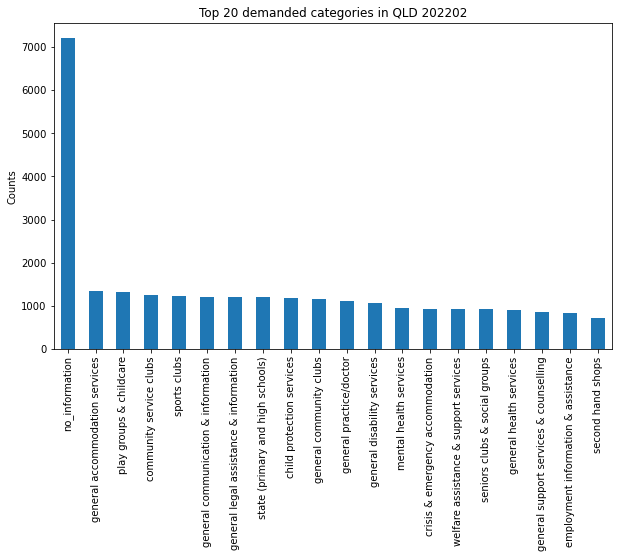

In [27]:
value_counts = df["CategoryName"].value_counts()
value_counts.head(20).plot(kind = "bar", ylabel = "Counts", figsize = (10, 6), title = "Top 20 demanded categories in QLD 202202")

In [28]:
value_counts

no_information                                   7198
general accommodation services                   1336
play groups & childcare                          1322
community service clubs                          1250
sports clubs                                     1231
general communication & information              1205
general legal assistance & information           1199
state (primary and high schools)                 1199
child protection services                        1184
general community clubs                          1159
general practice/doctor                          1121
general disability services                      1077
mental health services                            953
crisis & emergency accommodation                  928
welfare assistance & support services             923
seniors clubs & social groups                     922
general health services                           896
general support services & counselling            858
employment information & ass